
# Mobile Price Range Prediction
This notebook contains the workflow for predicting the price range of mobile devices based on their features using XGBoost. We will cover the following steps:
1. Data Preprocessing
2. Model Training
3. Model Evaluation
4. Hyperparameter Tuning
5. Feature Engineering and Selection
6. Advanced Model Evaluation
7. Model Explainability
8. Pipeline Creation


In [2]:
%pip install shap
%pip install imblearn

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   -- ------------------------------------ 30.7/456.1 kB 660.6 kB/s eta 0:00:01
   ------- -------------------------------- 81.9/456.1 kB 1.1 MB/s eta 0:00:01
   ----------------- ---------------------- 194.6/456.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------- ----- 389.1/456.1 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 2.2 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import shap

In [10]:
# Load the dataset
df = pd.read_csv('C:/Users/assem/Desktop/Creativia Alexandria Hub/Session_05/Train.csv')

# Display basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             1995 non-null   float64
 5   four_g         1995 non-null   float64
 6   int_memory     1995 non-null   float64
 7   m_dep          1995 non-null   float64
 8   mobile_wt      1996 non-null   float64
 9   n_cores        1996 non-null   float64
 10  pc             1995 non-null   float64
 11  px_height      1996 non-null   float64
 12  px_width       1998 non-null   float64
 13  ram            1998 non-null   float64
 14  sc_h           1999 non-null   float64
 15  sc_w           1999 non-null   float64
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


In [11]:
# Check for missing values
df.isnull().sum()

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Verify missing values are handled
df_imputed.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [12]:
# Create new feature: Screen Resolution
df_imputed['screen_resolution'] = df_imputed['px_width'] * df_imputed['px_height']
df_imputed.drop(['px_width', 'px_height'], axis=1, inplace=True)

In [13]:
# Define features and target
X = df_imputed.drop('price_range', axis=1)
y = df_imputed['price_range']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [15]:
# Initialize the XGBoost model
model = XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.75%


In [16]:
# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Best hyperparameters and corresponding accuracy
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Accuracy with Best Model: {accuracy_best * 100:.2f}%')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.90
Accuracy with Best Model: 92.00%


In [17]:
# Feature selection using XGBoost feature importance
selector = SelectFromModel(best_model, prefit=True)
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)

# Re-train the model with selected features
model_selected = XGBClassifier(random_state=42)
model_selected.fit(X_train_selected, y_train_smote)

# Evaluate with selected features
y_pred_selected = model_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f'Accuracy with Selected Features: {accuracy_selected * 100:.2f}%')

c:\Users\assem\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\assem\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Accuracy with Selected Features: 93.75%


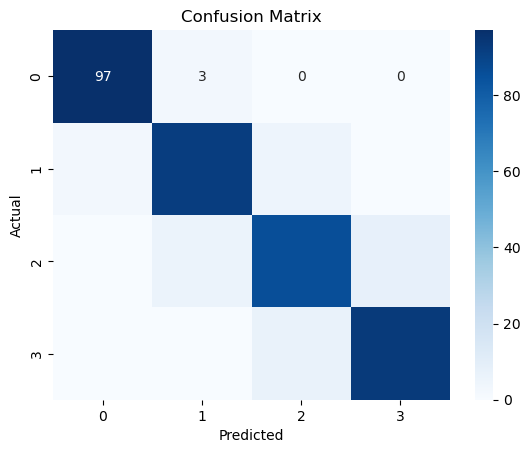

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       100
         1.0       0.91      0.92      0.92       100
         2.0       0.88      0.86      0.87       100
         3.0       0.92      0.93      0.93       100

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_best))

# ROC-AUC Curve and Precision-Recall Curve can be implemented for further evaluation

 98%|===================| 1569/1600 [00:33<00:00]        

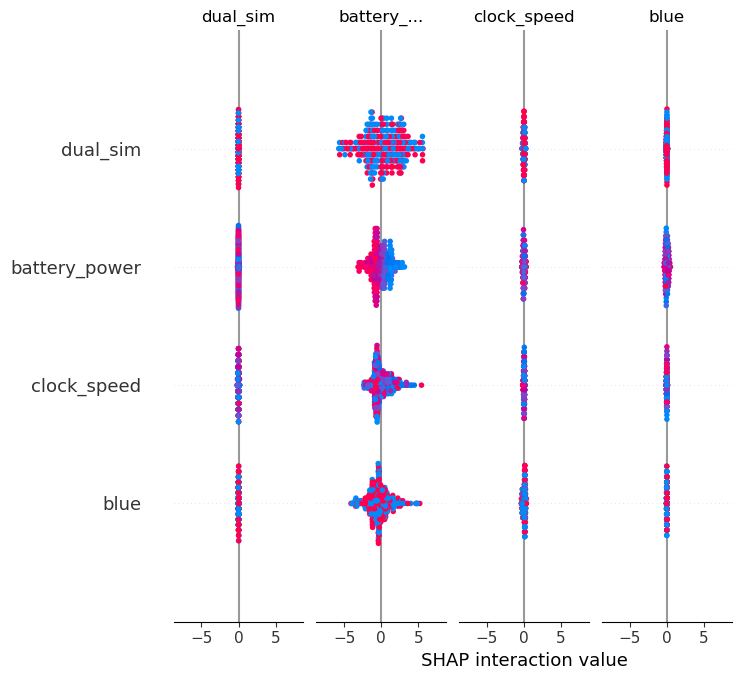

In [19]:
# Model explainability with SHAP
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [20]:
# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('model', XGBClassifier(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_pipeline = pipeline.predict(X_test)

# Evaluate the pipeline model
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
print(f'Pipeline Accuracy: {accuracy_pipeline * 100:.2f}%')

Pipeline Accuracy: 90.75%
